In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from datetime import datetime

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob


import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

import clean

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
from sklearn import metrics

In [2]:
# df1 = pd.read_csv('clean_dataset.csv')
# df = pd.read_csv('clean_dataset_old.csv')
df = pd.read_csv('one_hot_dataset.csv')
# df_fxrate = pd.read_csv('KS_train_data.csv')
# df_fxrate = clean.remove_unneeded(df_fxrate)
# df['goal_usd'] = df_fxrate.apply(lambda x: x.fx_rate* x.goal, axis=1)

In [3]:
df

,blurb,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,...,subcategory_154,subcategory_155,subcategory_156,subcategory_157,subcategory_158,hbl,log_hbl,hbd,goal_usd,sent_blurb
0,artist residence studio summer stretch wing land,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1941.320833,7.571124,527.027778,2800.0,0.000000
1,artist public art make installation washington mall occur january,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,571.683611,6.348586,960.000000,4500.0,0.000000
2,sequel favorite machine myphonehenge celebrate community virtual real world,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,169.123611,5.130630,1440.000000,5000.0,0.350000
3,film explore role value art education today history seminal california institute art,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,180.345833,5.194876,504.000000,6500.0,0.000000
4,need build kitchen habitable space self sustain farm artist residency ranch texas,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1230.450833,7.115136,720.000000,15000.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99959,small stage space jimmy well,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1467.321944,7.291194,720.000000,1500.0,-0.250000
99960,help create permanent home live comedy show class downtown rva,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,39.697222,3.681281,720.000000,50000.0,0.136364
99961,voix de ville pop imaginarium neo vaudeville musical extravaganza circus art comedy theatre tiny circus tent,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1247.185000,7.128644,880.511111,8300.0,0.000000
99962,help synetic theater create new studio produce amazing show season train awesome artist age,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,386.567778,5.957307,857.137778,3000.0,0.578788


In [3]:
# fx_rate_dict = pd.Series(df_fxrate.fx_rate.values, index=df_fxrate.currency).to_dict()

In [4]:
# df['goal_usd'] = df_fxrate.apply(lambda x: x.goal * fx_rate_dict[x.currency], axis=1)
# df['log_hbl'] = df.apply(lambda x: abs(x.log_hbl) , axis=1)


In [5]:
# encoder = ce.one_hot.OneHotEncoder(cols=['category', 'country', 'currency', 'subcategory', 'staff_pick'])

# df = encoder.fit_transform(df)

In [6]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
def sent_analysis(text):
    doc = nlp(text)
    return doc._.polarity

In [17]:
# df['sent_blurb'] = df.apply(lambda x: sent_analysis(x.blurb), axis=1)
df['len_blurb'] = df.apply(lambda x: len(x.blurb.split()), axis=1)

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop(['blurb', 'name', 'hbl', 'goal', 'funded'], axis=1))

In [19]:
# x_train, x_test, y_train, y_test = train_test_split(df.drop(['blurb', 'name', 'hbl', 'goal', 'funded'], axis=1), df.funded, test_size=0.3)
x_train, x_test, y_train, y_test = train_test_split(df_scaled, df.funded, test_size=0.3)

In [20]:
text_clf_nb = Pipeline([
    ('clf', MultinomialNB()),
])

In [21]:
text_clf_nb.fit(x_train, y_train)

Pipeline(steps=[('clf', MultinomialNB())])

In [22]:
def plot_roc(model, x, y, name='linear'):
    y_text = model.predict_proba(x)

    curve_linear = metrics.roc_curve(y, y_text[:, 1])

    # Compute AUC from the created ROC
    auc_linear = metrics.auc(curve_linear[0], curve_linear[1])

    plt.plot(curve_linear[0], curve_linear[1], label=f'{name} (area = %0.2f)' % auc_linear)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve');

    plt.legend();

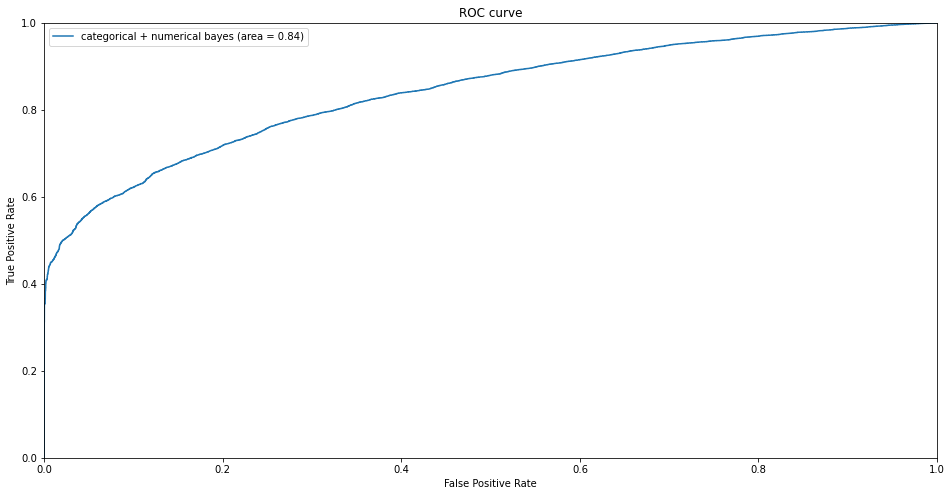

In [23]:
plot_roc(text_clf_nb, x_test, y_test, 'categorical + numerical bayes')

In [24]:
x_test.shape

(29990, 368)

In [25]:
predicted = text_clf_nb.predict(x_test)
metrics.accuracy_score(y_test, predicted)

0.7532510836945648

In [64]:
df = df.dropna(subset=['name'])
df = df.drop(df[df.name.str.isnumeric()].index)

In [65]:
df.name.isna().sum()

0

In [73]:

# name_vectorizer = CountVectorizer()
# name_vectors = name_vectorizer.fit_transform(df['name'])

blurb_vectorizer = CountVectorizer()
blurb_vectors = blurb_vectorizer.fit_transform(df['blurb'])
# print(blurb_vectors.shape)
# # x_features_train is a combined representation containing both the keywords and the text vectors
# x_features_train = sp.hstack([name_vectors, blurb_vectors, df['log_hbl'].values], format='csr')
# # x_features_train = sp.vstack([x_features_train, df['log_hbl'].values], format='csr')

# x_features_train

# tok = pd.SparseDataFrame(blurb_vectors, columns=blurb_vectorizer.get_feature_names(), index=df.index, default_fill_value=0)

# tok = pd.DataFrame({"blurb": pd.arrays.SparseArray(blurb_vectors)})
tok = pd.DataFrame.sparse.from_spmatrix(blurb_vectors, columns=blurb_vectorizer.get_feature_names())
tok
# y is decided above
# x_train_stack, x_test_stack, y_train_stack, y_test_stack = train_test_split(x_features_train, df.funded, test_size=0.2)

# text_val_stack, text_val_test_stack, target_val_stack, target_val_test_stack = train_test_split(x_test_stack, y_test_stack, test_size=0.50)

,aa,aaa,aaaahz,aaarrrrrr,aaauauughhh,aaberg,aac,aact,aaf,aahz,...,一個關於年輕華裔美國人尋找歸屬感的故事,原創貓咪水彩風紙膠帶,彡ame,新しいヒプホプアルブム,浮世絵ヒーロー,自道,黑人在中国,빈들에서,ﬁlm,ﬁnal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
stacked = pd.concat([tok.drop(['funded'], axis=1), df.drop(['blurb', 'name', 'hbl', 'goal'], axis=1)], axis=1)


In [69]:
x_train_stack, x_test_stack, y_train_stack, y_test_stack = train_test_split(stacked, stacked.funded, test_size=0.2)


In [75]:
x_train_stack.shape

(79968, 59405)

In [77]:
clf_nb_stack = MultinomialNB() 
clf_nb_stack.fit(x_train_stack, y_train_stack)

MemoryError: Unable to allocate 35.4 GiB for an array with shape (59405, 79968) and data type object

In [71]:
stacked

,aa,aaa,aaaahz,aaarrrrrr,aaauauughhh,aaberg,aac,aact,aaf,aahz,...,subcategory_153,subcategory_154,subcategory_155,subcategory_156,subcategory_157,subcategory_158,log_hbl,hbd,goal_usd,sent_blurb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.571124,527.027778,2800.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.348586,960.000000,4500.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.130630,1440.000000,5000.0,0.350000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.194876,504.000000,6500.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.115136,720.000000,15000.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,7.291194,720.000000,1500.0,-0.250000
99960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,3.681281,720.000000,50000.0,0.136364
99961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,7.128644,880.511111,8300.0,0.000000
99962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,5.957307,857.137778,3000.0,0.578788


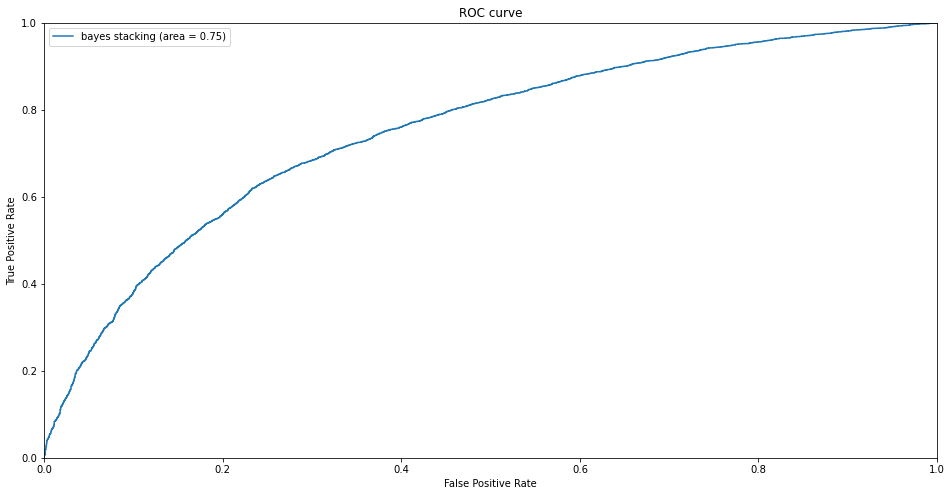

In [17]:
plot_roc(clf_nb_stack, text_val_test_stack, target_val_test_stack, 'bayes stacking')

In [18]:
predicted = clf_nb_stack.predict_proba(x_test_stack)
result = []
for x in predicted:
    result.append(to_boolean(x))
    
metrics.accuracy_score(y_test_stack, result)

0.6943842860740368

# Evaluation: